<a href="https://colab.research.google.com/github/M-Sravya/drug-review/blob/main/rnn_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file_path = '/content/drive/MyDrive/CHT/drugsComTrain_raw.csv'
test_file_path = '/content/drive/MyDrive/CHT/drugsComTest_raw.csv'


In [ ]:
# Load the datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

In [ ]:
# Concatenate train and test data for preprocessing
data = pd.concat([train_data, test_data])

In [ ]:
# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['clean_review'] = data['review'].apply(preprocess_text)

In [ ]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['clean_review'])
X = tokenizer.texts_to_sequences(data['clean_review'])
maxlen = 100  # Define maxlen for padding
X = pad_sequences(X, padding='post', maxlen=maxlen)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [ ]:
# Function to build and compile GRU model
def build_gru_model(output_dim, output_units, loss, activation='softmax'):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(output_units, activation=activation))
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    return model


In [ ]:
# @title Default title text
# Task 01: Predicting a patient's condition based on reviews (Classification)
le_condition = LabelEncoder()
y_condition = le_condition.fit_transform(data['condition'])

X_train, X_test, y_train, y_test = train_test_split(X, y_condition, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model_condition = build_gru_model(output_dim=100, output_units=y_train.shape[1], loss='categorical_crossentropy')
history_condition = model_condition.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

y_pred_condition = model_condition.predict(X_test)
y_pred_condition_classes = np.argmax(y_pred_condition, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print('Classification Report for Condition Prediction:\n', classification_report(y_test_classes, y_pred_condition_classes))


1345/1345 [==============================] - 48s 36ms/step
Classification Report for Condition Prediction:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           3       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         5
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         4
          20       0.00      0.00      0.00        20
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         4
          23       0.00      0.00      0.00         1
          24       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Task 02: Estimating drug ratings from reviews (Regression)
y_rating = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y_rating, test_size=0.2, random_state=42)

model_rating = build_gru_model(output_dim=100, output_units=1, loss='mean_squared_error', activation='linear')
history_rating = model_rating.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

y_pred_rating = model_rating.predict(X_test)
print('Mean Squared Error for Rating Prediction:', mean_squared_error(y_test, y_pred_rating))


1345/1345 [==============================] - 57s 42ms/step
Mean Squared Error for Rating Prediction: 4.890658360617866


In [ ]:
# Task 03: Identifying elements that make reviews helpful (Linear Regression)
# Not directly suitable for GRU, but we can transform the task to classification/regression with text data
data['usefulCount'] = data['usefulCount'].fillna(0)
data['usefulCount'] = data['usefulCount'].astype(int)
y_helpful = data['usefulCount']

X_train, X_test, y_train, y_test = train_test_split(X, y_helpful, test_size=0.2, random_state=42)

model_helpful = build_gru_model(output_dim=100, output_units=1, loss='mean_squared_error', activation='linear')
history_helpful = model_helpful.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

y_pred_helpful = model_helpful.predict(X_test)
print('Mean Squared Error for Helpful Prediction:', mean_squared_error(y_test, y_pred_helpful))


1345/1345 [==============================] - 49s 36ms/step
Mean Squared Error for Helpful Prediction: 1072.8518877199494


In [ ]:
# Task 04: Understanding patients with negative reviews (Sentiment Analysis)
def get_sentiment(score):
    if score >= 7:
        return 2  # Positive
    elif score <= 4:
        return 0  # Negative
    else:
        return 1  # Neutral

data['sentiment'] = data['rating'].apply(get_sentiment)
y_sentiment = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model_sentiment = build_gru_model(output_dim=100, output_units=y_train.shape[1], loss='categorical_crossentropy')
history_sentiment = model_sentiment.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

y_pred_sentiment = model_sentiment.predict(X_test)
y_pred_sentiment_classes = np.argmax(y_pred_sentiment, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print('Classification Report for Sentiment Analysis:\n', classification_report(y_test_classes, y_pred_sentiment_classes))


1345/1345 [==============================] - 45s 34ms/step
Classification Report for Sentiment Analysis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     10722
           1       0.00      0.00      0.00      3945
           2       0.66      1.00      0.79     28346

    accuracy                           0.66     43013
   macro avg       0.22      0.33      0.26     43013
weighted avg       0.43      0.66      0.52     43013



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1345/1345 [==============================] - 46s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Sentiment Classification:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     10722
           1       0.00      0.00      0.00      3945
           2       0.66      1.00      0.79     28346

    accuracy                           0.66     43013
   macro avg       0.22      0.33      0.26     43013
weighted avg       0.43      0.66      0.52     43013



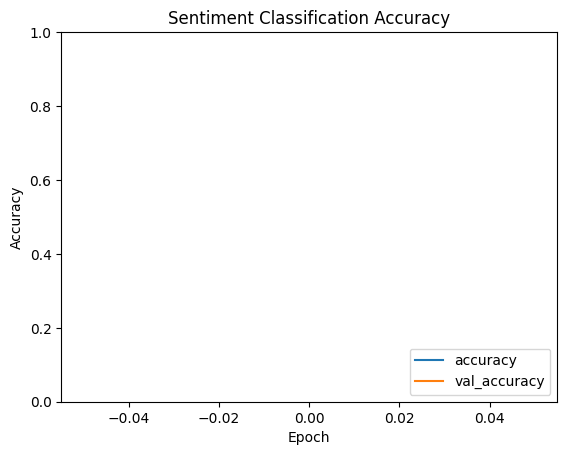

In [ ]:
# Task 05: Classifying reviews as positive, negative, or neutral (Classification)

# Preprocessing already done

# Sentiment classification based on rating (similar to Task 04)
y_sentiment = data['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build and train the GRU model for sentiment classification
model_sentiment = build_gru_model(output_dim=100, output_units=y_train.shape[1], loss='categorical_crossentropy')
history_sentiment = model_sentiment.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

# Predict and evaluate
y_pred_sentiment = model_sentiment.predict(X_test)
y_pred_sentiment_classes = np.argmax(y_pred_sentiment, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print('Classification Report for Sentiment Classification:\n', classification_report(y_test_classes, y_pred_sentiment_classes))

# Plotting training history for visualizations
def plot_training_history(history, title):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()

plot_training_history(history_sentiment, 'Sentiment Classification Accuracy')


                                drugName  condition  \
310      Aspirin / butalbital / caffeine   Migraine   
335   Acetaminophen / aspirin / caffeine  Pain/Feve   
1275  Acetaminophen / aspirin / caffeine   Migraine   
1362  Acetaminophen / aspirin / caffeine   Migraine   
1532                  Aspirin / caffeine       Pain   

                                                 review  rating  
310   "This drug is phenomenal for migraines as long...      10  
335   "I don&#039;t get headaches very often, but wh...      10  
1275  "I have had migraines for almost 40 years. I h...      10  
1362  "My Migraine headache starts with what they ca...       8  
1532  "This med really works plus the little bit of ...      10  


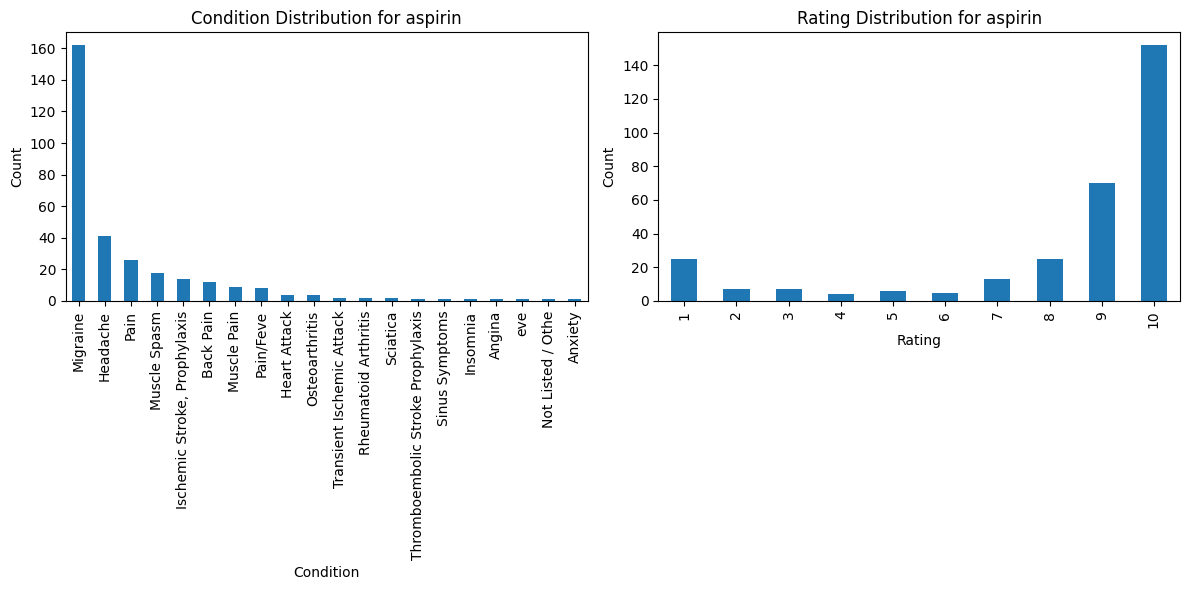

In [ ]:
# Task 06: Exploring drugs and its associated conditions (Filtering)

def explore_drug(drug_name):
    filtered_data = data[data['drugName'].str.contains(drug_name, case=False, na=False)]
    if filtered_data.empty:
        print(f"No data found for drug: {drug_name}")
        return pd.DataFrame()
    return filtered_data[['drugName', 'condition', 'review', 'rating']]

# Example usage
explored_drug = explore_drug('aspirin')
if not explored_drug.empty:
    print(explored_drug.head())

# Visualizing the distribution of conditions and ratings for a specific drug
def plot_drug_distribution(drug_name):
    filtered_data = explore_drug(drug_name)
    if filtered_data.empty:
        return
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    filtered_data['condition'].value_counts().plot(kind='bar')
    plt.title(f'Condition Distribution for {drug_name}')
    plt.xlabel('Condition')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    filtered_data['rating'].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Rating Distribution for {drug_name}')
    plt.xlabel('Rating')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Example usage
plot_drug_distribution('aspirin')


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True